In [101]:
import torch
import torch.nn.functional as F

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram

import matplotlib.pyplot as plt

In [102]:
DAFX_TO_USE = [
    # 'mda MultiBand',
    # 'clean',
    'mda Delay',
    'mda Overdrive',
    # # 'mda Ambience',
    'mda RingMod',
    # 'mda Leslie',
    # 'mda Combo',
    # 'mda Thru-Zero Flanger',
    # 'mda Loudness',
    # 'mda Limiter'
    'mda Dynamics',
]

In [103]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 1
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/1pkbua63/checkpoints/epoch=147-step=46324.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [104]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [105]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=131_072,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [106]:
def get_spectrogram_and_reconstruction(audio, model):
    x_s = audio_to_spectrogram(audio).to(DEVICE)
    x_hat, _, _, _ = model(x_s)

    return x_s, x_hat

In [107]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()
print("Model weighted loaded")

Model weighted loaded


In [108]:
# fx_name = (x, x_hat)
data = dict()

In [109]:
for fx_name in DAFX_TO_USE:
    loader = get_dataset(dafx_from_name(fx_name))
    x = next(iter(loader))
    X, X_hat = get_spectrogram_and_reconstruction(x, model)

    data[fx_name.split()[-1]] = (X, X_hat)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 42908.48it/s]


Loaded 88 files for train = 66.89 hours.



100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 3836.63it/s]


Loaded 88 files for train = 66.89 hours.



100%|████████████████████████████████████████| 88/88 [00:00<00:00, 38640.99it/s]


Loaded 88 files for train = 66.89 hours.



100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 6461.59it/s]


Loaded 88 files for train = 66.89 hours.


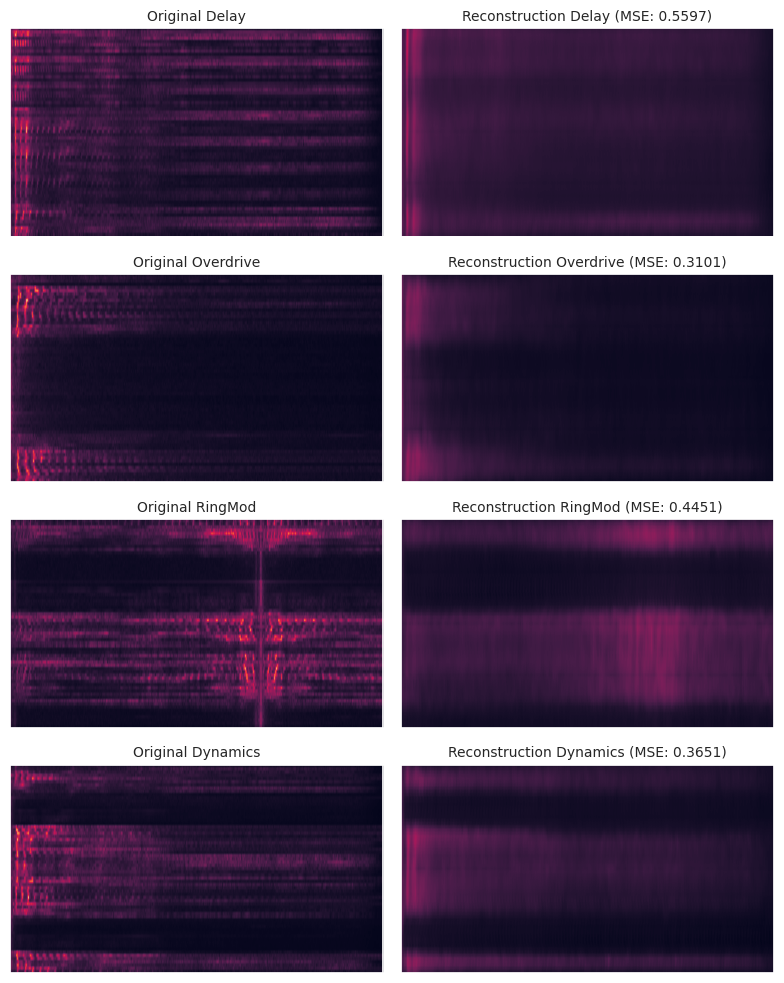

In [110]:
fig, axes = plt.subplots(len(data), 2, figsize=(8,2.5*len(data)))

# for each dimension
for i, items in enumerate(data.items()):
    fx_name, spectrograms = items
    X, X_hat = spectrograms

    # calculate error
    mse = F.mse_loss(X.squeeze(), X_hat.squeeze())

    # find minimum of minima & maximum of maxima
    minmin = min([torch.min(X).item(), torch.min(X_hat).item()])
    maxmax = max([torch.max(X).item(), torch.max(X_hat).item()])

    ax1 = axes[i, 0].imshow(X.squeeze().cpu().detach().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax,
                            )

    ax2 = axes[i, 1].imshow(X_hat.squeeze().cpu().detach().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    axes[i, 0].set_title(f"Original {fx_name}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {fx_name} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# add space for colour bar
fig.subplots_adjust(right=0.85)

plt.tight_layout()
plt.savefig(f"./figures/reconstructions/{CHECKPOINT_ID}_{len(data)}fx_reconstructions.png")